## Day 14: Day 14: Regolith Reservoir

The distress signal leads you to a giant waterfall! Actually, hang on - the signal seems like it's coming from the waterfall itself, and that doesn't make any sense. However, you do notice a little path that leads behind the waterfall.

Correction: the distress signal leads you behind a giant waterfall! There seems to be a large cave system here, and the signal definitely leads further inside.

As you begin to make your way deeper underground, you feel the ground rumble for a moment. Sand begins pouring into the cave! If you don't quickly figure out where the sand is going, you could quickly become trapped!

Fortunately, your familiarity with analyzing the path of falling material will come in handy here. You scan a two-dimensional vertical slice of the cave above you (your puzzle input) and discover that it is mostly air with structures made of rock.

Your scan traces the path of each solid rock structure and reports the x,y coordinates that form the shape of the path, where x represents distance to the right and y represents distance down. Each path appears as a single line of text in your scan. After the first point of each path, each point indicates the end of a straight horizontal or vertical line to be drawn from the previous point. For example:

```
498,4 -> 498,6 -> 496,6
503,4 -> 502,4 -> 502,9 -> 494,9
```

In [1]:
import pytest
from icecream import ic
from vectors import Vector

In [3]:
def load_input(filename):
    with open(filename, 'r') as f_input:
        for line in f_input:
            yield [
                Vector(*[int(num) for num in point.split(',')])
                for point in line.split(' -> ')
            ]

for points in load_input('sample.txt'):
    print(' -> '.join(
        f'{point.x},{point.y}'
        for point in points
    ))
    

498,4 -> 498,6 -> 496,6
503,4 -> 502,4 -> 502,9 -> 494,9


This scan means that there are two paths of rock; the first path consists of two straight lines, and the second path consists of three straight lines. (Specifically, the first path consists of a line of rock from 498,4 through 498,6 and another line of rock from 498,6 through 496,6.)

The sand is pouring into the cave from point 500,0.

Drawing rock as #, air as ., and the source of the sand as +, this becomes:

```
  4     5  5
  9     0  0
  4     0  3
0 ......+...
1 ..........
2 ..........
3 ..........
4 ....#...##
5 ....#...#.
6 ..###...#.
7 ........#.
8 ........#.
9 #########.
```

In [18]:
import itertools
from show import Grid

g = Grid(1024, 512)
all_x = set([
    point.x
    for points in load_input('sample.txt')
    for point in points
])
min_x = min(all_x)
max_x = max(all_x)
assert ic(min_x) == 494
assert ic(max_x) == 503

ic| min_x: 494
ic| max_x: 503


In [13]:
width = max_x - min_x + 10
all_y = [
    point.y
    for points in load_input('sample.txt')
    for point in points

]
min_y = min(all_y)
max_y = max(all_y)
height = max_x - min_x + 10

offset = Vector(min_x, min_y)

ic(offset, width, height, min_x, max_x, min_y, max_y)

ic| all_x: {498, 508}, min_x: 498, max_x: 508
ic| offset: Vector(x=498, y=15)
    width: 20
    height: 20
    min_x: 498
    max_x: 508
    min_y: 15
    max_y: 16


(Vector(x=498, y=15), 20, 20, 498, 508, 15, 16)

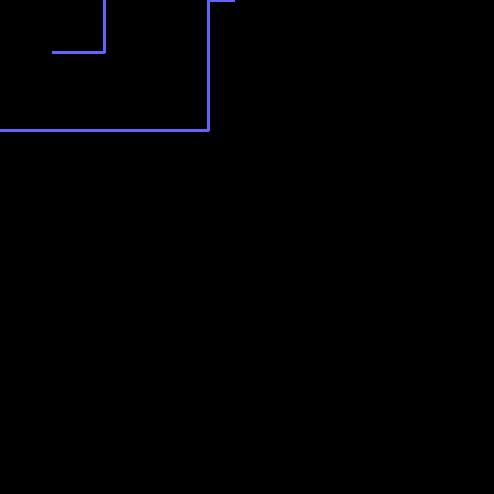

In [5]:
from show import Grid

scale = 512 // width
g = Grid(width, height, scale=scale)
for points in load_input('sample.txt'):
    for (start, end) in itertools.pairwise(points):
        g.line(start - offset, end-offset)
g.img

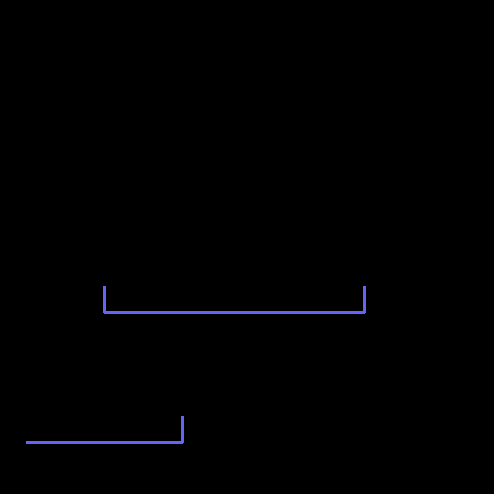

In [6]:
from show import Grid

scale = 512 // width
g = Grid(width, height, scale=scale)
for points in load_input('input.txt'):
    for (start, end) in itertools.pairwise(points):
        g.line(start - offset, end-offset)
g.img

Sand is produced one unit at a time, and the next unit of sand is not produced until the previous unit of sand comes to rest. A unit of sand is large enough to fill one tile of air in your scan.

A unit of sand always falls down one step if possible. If the tile immediately below is blocked (by rock or sand), the unit of sand attempts to instead move diagonally one step down and to the left. If that tile is blocked, the unit of sand attempts to instead move diagonally one step down and to the right. Sand keeps moving as long as it is able to do so, at each step trying to move down, then down-left, then down-right. If all three possible destinations are blocked, the unit of sand comes to rest and no longer moves, at which point the next unit of sand is created back at the source.

So, drawing sand that has come to rest as o, the first unit of sand simply falls straight down and then stops:

......+...
..........
..........
..........
....#...##
....#...#.
..###...#.
........#.
......o.#.
#########.

The second unit of sand then falls straight down, lands on the first one, and then comes to rest to its left:

......+...
..........
..........
..........
....#...##
....#...#.
..###...#.
........#.
.....oo.#.
#########.

After a total of five units of sand have come to rest, they form this pattern:

......+...
..........
..........
..........
....#...##
....#...#.
..###...#.
......o.#.
....oooo#.
#########.

After a total of 22 units of sand:

......+...
..........
......o...
.....ooo..
....#ooo##
....#ooo#.
..###ooo#.
....oooo#.
...ooooo#.
#########.

Finally, only two more units of sand can possibly come to rest:

......+...
..........
......o...
.....ooo..
....#ooo##
...o#ooo#.
..###ooo#.
....oooo#.
.o.ooooo#.
#########.

Once all 24 units of sand shown above have come to rest, all further sand flows out the bottom, falling into the endless void. Just for fun, the path any new sand takes before falling forever is shown here with ~:

.......+...
.......~...
......~o...
.....~ooo..
....~#ooo##
...~o#ooo#.
..~###ooo#.
..~..oooo#.
.~o.ooooo#.
~#########.
~..........
~..........
~..........

Using your scan, simulate the falling sand. How many units of sand come to rest before sand starts flowing into the abyss below?

In [ ]:
...

In [ ]:
sol = solution_one('input.txt')
print(f"Solution part one: {sol}")